# 02_CLASSIFICATION - SUBSCRIPTION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

## 1. LOAD DATA

In [2]:
df = pd.read_csv("cleaned_data.csv")
print("Shape:", df.shape)

Shape: (3900, 28)


## 2. ENCODE TARGET

In [3]:
df['Subscription_enc'] = df['Subscription Status'].map({'Yes':1, 'No':0})

print("\nTarget Distribution:")
print(df['Subscription_enc'].value_counts(normalize=True))


Target Distribution:
Subscription_enc
0    0.73
1    0.27
Name: proportion, dtype: float64


## 3. DROP UNNECESSARY COLUMNS

In [4]:
drop_cols = [
    'Customer ID',
    'Item Purchased',
    'Location',
    'Size',
    'Color',
    'Payment Method',
    'Preferred Payment Method',
    'Frequency of Purchases',
    'Subscription Status',
    'Sentiment',
    'Loyalty_Tier'
]

df = df.drop(columns=drop_cols, errors='ignore')

## 4. ONE-HOT ENCODE CATEGORICALS

In [5]:
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df = df.select_dtypes(include=[np.number])

print("\nFinal Columns Used:")
print(df.columns)


Final Columns Used:
Index(['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases',
       'High_Value', 'Discount_Flag', 'Discount_Sensitivity', 'F_score',
       'M_score', 'R_score', 'RFM_Score', 'Subscription_enc'],
      dtype='object')


## 5. SPLIT FEATURES & TARGET

In [6]:
X = df.drop(columns=['Subscription_enc'])
y = df['Subscription_enc']

## 6. TRAIN-TEST SPLIT

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## 7. SCALING

In [8]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

## 8. MODELS (with class_weight)

In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        random_state=42,
        eval_metric='logloss',
        verbosity=0,
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])
    )
}

results = []

for name, model in models.items():

    model.fit(X_train_sc, y_train)

    y_pred  = model.predict(X_test_sc)
    y_proba = model.predict_proba(X_test_sc)[:,1]

    auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Accuracy": (y_pred == y_test).mean(),
        "ROC-AUC": auc
    })

    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))

results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)

print("\nModel Comparison:")
print(results_df)

best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name}")


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       1.00      0.81      0.90       569
           1       0.67      1.00      0.80       211

    accuracy                           0.86       780
   macro avg       0.83      0.91      0.85       780
weighted avg       0.91      0.86      0.87       780


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       569
           1       0.67      0.78      0.72       211

    accuracy                           0.84       780
   macro avg       0.79      0.82      0.80       780
weighted avg       0.85      0.84      0.84       780


--- XGBoost ---
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       569
           1       0.66      0.74      0.70       211

    accuracy                           0.83       780
   macro avg       0.78      0.80      0.79       780
weigh

## 9. ROC CURVE

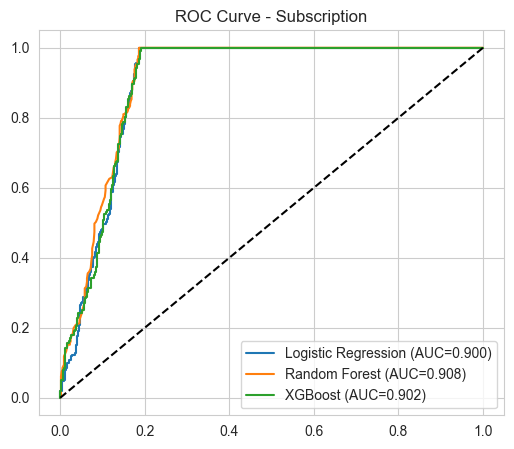

In [10]:
plt.figure(figsize=(6,5))

for name, model in models.items():
    y_proba = model.predict_proba(X_test_sc)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve - Subscription")
plt.legend()
plt.show()